# A Guide for Creating Your Data Science Brand
## *Analyzing Kaggle's 2021 survey data to help you understand who to create for and what they need*
## *Author: Ani Madurkar*

# I. Introduction

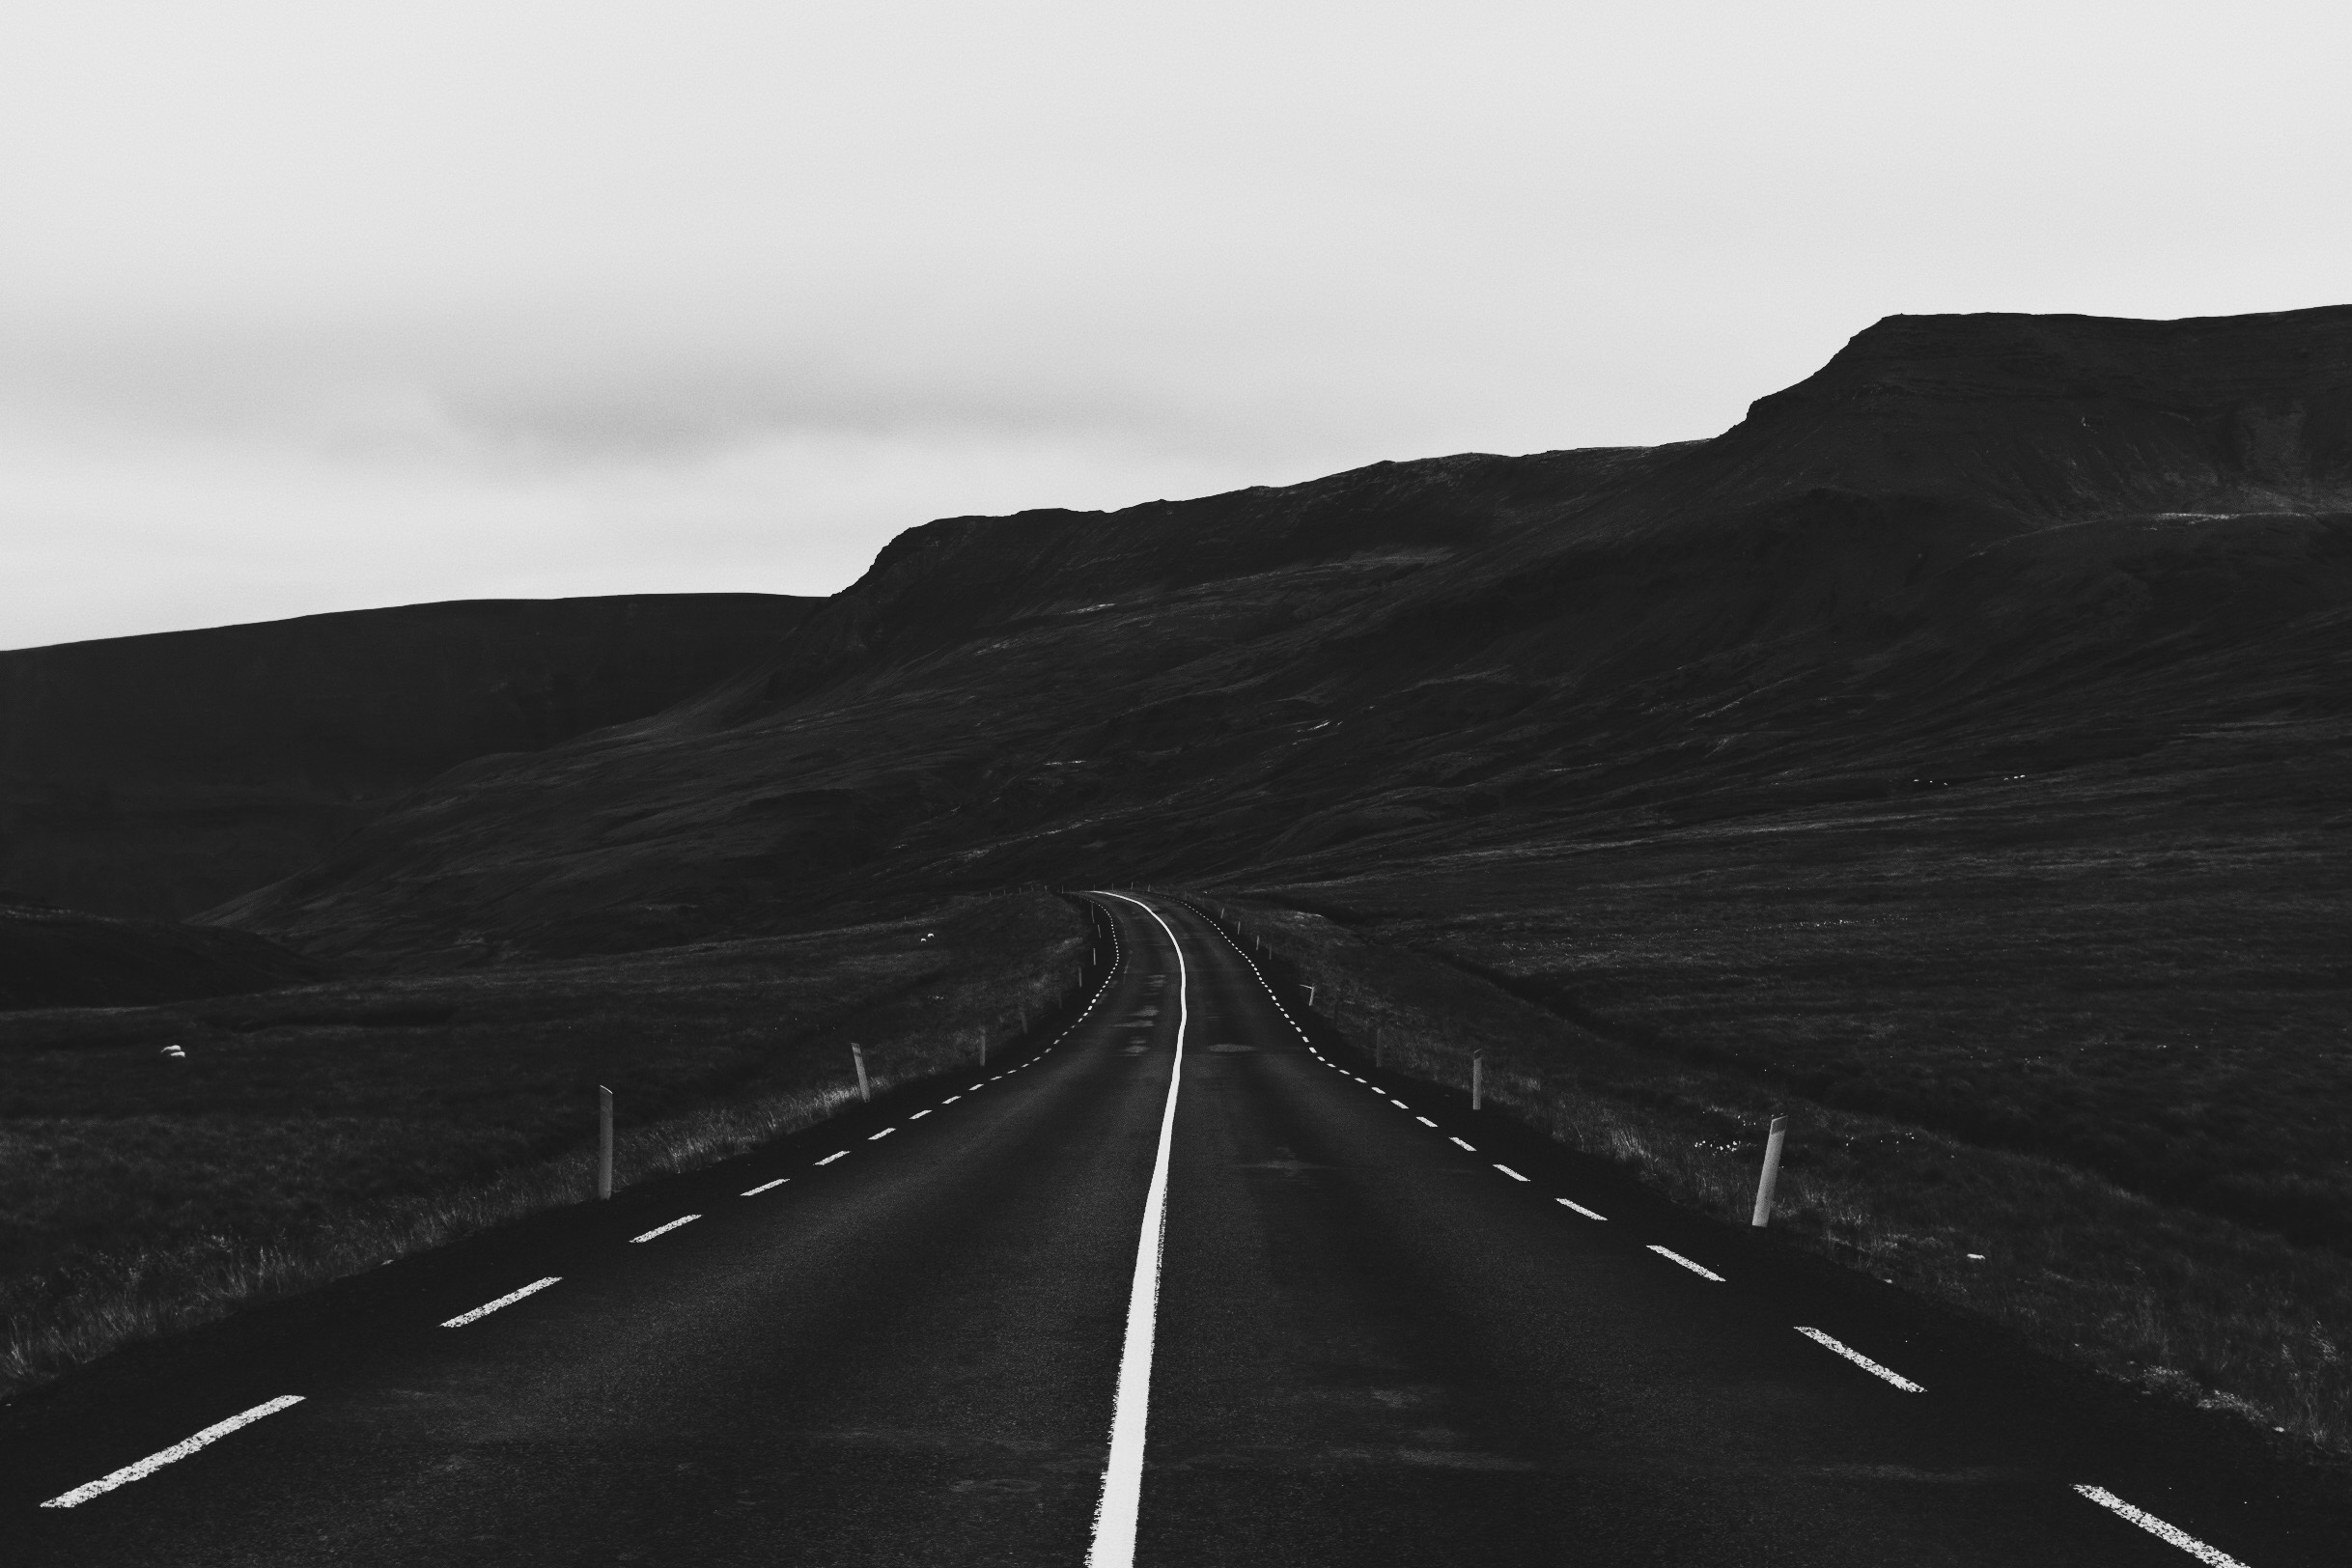

# Objective

I recently graduated from a Masters in Applied Data Science from University of Michigan and have started a Data Scientist/Engineer role this year alongside multiple Research Assistant engagements for the past year. With that and my obsession with this craft, I've taken up writing and creating content to establish my brand in this space. My content is currently focused on Applied Machine Learning & Data Science that helps others see the art & science of the craft. My primary areas of publishing are Medium and Twitter, but a large pattern I've noticed is that there's a lot of content at the PhD researcher level and at the super beginner level. There's not much content out there written by the intermediate/advanced professionals that show you how to be better tomorrow. That's where I hope to focus my brand in, and that is also the motivation of this analysis. If nothing else, I hope to better understand what my peers are working on, need help with, and where their attention is for media.

My initial hypothesis that, like me, intermediate professionals often are confused and overwhelmed with what to learn next. Even the curious & ambitious learners can get lost and it doesn't help that there is a ton of noise related to this field out there. What I, and I'd imagine many in my position, are looking for are applied guides that don't inundate with theory, confusion, or are shallow dives for early learners. So this will be for those already decently proficient looking to elevate their Data Science & Machine Learning game by building their brand.

# 2021 Kaggle Data Science & Machine Learning Survey

The challenge objective: tell a data story about a subset of the data science community represented in this survey, through a combination of both narrative text and data exploration. A “story” could be defined any number of ways, and that’s deliberate. The challenge is to deeply explore (through data) the impact, priorities, or concerns of a specific group of data science and machine learning practitioners. That group can be defined in the macro (for example: anyone who does most of their coding in Python) or the micro (for example: female data science students studying machine learning in masters programs). This is an opportunity to be creative and tell the story of a community you identify with or are passionate about!

Can you identify any insights about any of the subgroups within the Kaggle community?

The subgroup I will focus on are going to be working professionals with at least 1 year of ML experience in this field and use some media form to educate themselves. Furthermore, my peers are primarily Data Scientists, Machine Learning Engineers, Data Engineers, and Data Analysts so I'll filter down to these roles as well.

# Imports and Subgroup Filter

In [ ]:
from IPython.display import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import plotly
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, plot_confusion_matrix, classification_report
import xgboost
from xgboost import XGBClassifier

RANDOM_SEED = 0

kaggle_survey_data = pd.read_csv('../input/kaggle-survey-2021/kaggle_survey_2021_responses.csv', header=1, low_memory=False)
# list(kaggle_survey_data.columns)
# kaggle_survey_data.head()
years_of_ML_exp = ['1-2 years', '2-3 years', '3-4 years', '4-5 years', '5-10 years', '10-20 years', '20 or more years']
relevant_titles = ['Data Scientist', 'Data Analyst', 'Data Engineer', 'Machine Learning Engineer']
ml_exp_learners = kaggle_survey_data[(kaggle_survey_data['For how many years have you used machine learning methods?'].isin(years_of_ML_exp)) & 
                                     (kaggle_survey_data['Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice - None']!='None') &
                                     (kaggle_survey_data['Select the title most similar to your current role (or most recent title if retired): - Selected Choice'].isin(relevant_titles))]

color_discrete_map = {'Data Scientist': 'darkcyan', 'Machine Learning Engineer': 'darkgoldenrod', 
                      'Data Engineer': 'darksalmon', 'Data Analyst': 'darkolivegreen'}

In [ ]:
def percentOfTotal(dataframe,column_name):

    counts = dataframe[column_name].value_counts(dropna=False)
    percentages = round(counts*100/len(dataframe[column_name]),1)
    percentages = percentages.reset_index().rename(columns={0: 'Percent'})
    percentages = percentages[percentages['Percent']>0].sort_values('Percent')
    
    return percentages

def createChoropleth(dataframe, title, max_value):
    
    fig = px.choropleth(dataframe, 
                        locations = 'Country',  
                        color = 'Percent',
                        locationmode = 'country names', 
                        color_continuous_scale = 'plasma',
                        title = title,
                        range_color = [0, max_value])

    fig.update(layout=dict(title=dict(x=0.5)))
    fig.show()
    
def createSunburst(dataframe, path, values, title, color, color_discrete_map=None):
    
    fig =px.sunburst(
        dataframe,
        path=path,
        values=values,
        title=title,
        color=color,
        color_discrete_map=color_discrete_map)
    
    fig.show()
    plt.show()
    
    
def createBarChart(dataframe, x, y, color, title, color_discrete_map=None, text=None, hover_data=None, barmode=None, xaxis=None):

    fig = px.bar(dataframe, x=x, y=y,
                 color=color, barmode=barmode, hover_data=hover_data,
                 title=title, text=text, color_discrete_map=color_discrete_map)
    fig.update_layout(xaxis=xaxis)
    fig.show()
    
def getRenameColumnsDictionary(column_names):
    
    column_names_cleaned = [x.split(' - ')[-1].strip() for x in column_names]
    column_names_cleaned_dict = {x:y for x,y in zip(column_names, column_names_cleaned)}

    return column_names_cleaned_dict

def cleanAndTransformMultipleChoiceColumns(dataframe, question_string, columns_to_index, additional_rename_dict=None):

    relevant_columns = [col for col in dataframe.columns if question_string in col]
    relevant_columns_index = [dataframe.columns.get_loc(c) for c in relevant_columns]

    relevant_columns_dict = getRenameColumnsDictionary(relevant_columns)
    if additional_rename_dict:
        relevant_columns_dict.update(additional_rename_dict)
    dataframe = dataframe.rename(columns=relevant_columns_dict)
    
    cleaned_dataframe = dataframe.set_index(columns_to_index).iloc[:,relevant_columns_index[0]-len(columns_to_index):relevant_columns_index[-1]+1-len(columns_to_index)].stack().reset_index().drop(columns=0)
    
    return cleaned_dataframe

In [ ]:
respondents_df = pd.DataFrame([kaggle_survey_data.shape[0], ml_exp_learners.shape[0]], columns=['Number of Respondents'], 
                              index=['Total Kaggle 2021 Survey Respondents', 'ML Learners with Experience'])
respondents_df = respondents_df.reset_index().rename(columns={'index': 'Respondents'})

createBarChart(respondents_df, 'Number of Respondents', 'Respondents', color='Respondents', 
               title='Number of Respondents After Filtering to Subgroup', text='Number of Respondents')

Seems we filtered out about 20K respondents; very interesting! This gives us a really specific focus to start with, which is great. It's easy enough to expand as we need, but since I know these are primarily the people who are dealing with my day-to-day it makes sense to focus here first. Let's try to understand who the remaining people are, starting with demographics.

# II. Analysis of Learners with Machine Learning Experience

# Gender, Age, and Location

In [ ]:
ml_exp_learners = ml_exp_learners.rename(columns={'What is your age (# years)?': 'Age (# years)', 
                                                  'What is your gender? - Selected Choice': 'Gender',
                                                  'In which country do you currently reside?': 'Country'})
ml_exp_learners['Age (# years)'] = pd.Categorical(ml_exp_learners['Age (# years)'], 
                                        categories=['18-21', '22-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-69', '70+'],
                                        ordered=True)
ml_exp_learners = ml_exp_learners.sort_values('Age (# years)')

country_age_gender_percents = percentOfTotal(ml_exp_learners, ['Country', 'Age (# years)', 'Gender'])
country_age_gender_percents = country_age_gender_percents.sort_values('Age (# years)')

gender_color_discrete_map = {'Man': '#1f77b4', 'Woman': '#ff7f0e', 'Nonbinary': '#2ca02c', 'Prefer to self-describe': '#9467bd', 'Prefer not to say': '#7f7f7f'}
createBarChart(country_age_gender_percents, x='Age (# years)', y='Percent', color='Gender', 
               hover_data=['Country'], barmode='group',title='Respondents by Age (# years), Gender, and Country', color_discrete_map=gender_color_discrete_map)
createSunburst(country_age_gender_percents, path=['Gender', 'Age (# years)', 'Country'], values='Percent', color='Gender',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=gender_color_discrete_map)

Unfortunately, it's not surprising to see such a disparate difference between men and women here. The field has a lot of work to do to create equality of opportunity for women, and this only confirms that sad reality. The primary age range across both genders though is 25-29, so your beginner/intermediate practitioner is likely to be most common. Men have more in higher age ranges (30-34, 35-39, 40-44) but women are right up there with relatively high percentages for the younger years (22-24 and 25-29). In each case, we see India having the top most percentage with US a strong second. Women do seem to have very high percentages in India in comparison to other countries, but it is especially notable for the 18-21 range. For men, US is a strong competitor with India in representation here but for women, India appears to be completely dominating.

# Title, Education, and Location

In [ ]:
ml_exp_learners = ml_exp_learners.rename(columns={'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?': 'Degree',
                                                  'Select the title most similar to your current role (or most recent title if retired): - Selected Choice': 'Current Title'})
ml_exp_learners['Degree'] = pd.Categorical(ml_exp_learners['Degree'], 
                                        categories=['I prefer not to answer', 'No formal education past high school', 'Some college/university study without earning a bachelor’s degree', 'Bachelor’s degree', 'Master’s degree', 'Doctoral degree', 'Professional doctorate'],
                                        ordered=True)

country_degree_percents = percentOfTotal(ml_exp_learners, ['Country', 'Degree'])
country_degree_percents = country_degree_percents[country_degree_percents['Percent']>0].sort_values(['Degree', 'Percent'])

for degree_ans in country_degree_percents['Degree'].unique():
    country_degree_percents_filtered = country_degree_percents[country_degree_percents['Degree']==degree_ans]
    createChoropleth(country_degree_percents_filtered, 
                     f'Highest Level of Formal Education Planned or Attained by Country - {degree_ans}', 
                     max(country_degree_percents_filtered['Percent'])+5)

In [ ]:
country_degree_title_percents = percentOfTotal(ml_exp_learners, ['Country', 'Degree', 'Current Title'])

createBarChart(country_degree_title_percents, x='Degree', y='Percent', color='Current Title', 
               hover_data=['Country'], title='Respondents by Current Title, Education Level, and Location', color_discrete_map=color_discrete_map,
               xaxis={'categoryorder':'total descending'})
createSunburst(country_degree_title_percents, path=['Current Title','Degree','Country'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

# III. Company Information

In [ ]:
ml_exp_learners = ml_exp_learners.rename(columns={'In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice': 'Employer Industry',
                                                  'What is the size of the company where you are employed?': 'Company Size',
                                                  'Approximately how many individuals are responsible for data science workloads at your place of business?': 'Individuals Responsible for Data Science',
                                                  'Does your current employer incorporate machine learning methods into their business?': 'Employer Incorporating Machine Learning'})

title_industry_percents = percentOfTotal(ml_exp_learners, ['Current Title', 'Employer Industry'])
title_industry_percents['Employer Industry'] = title_industry_percents['Employer Industry'].fillna('None Given')
title_employer_percents = percentOfTotal(ml_exp_learners, ['Current Title', 'Employer Industry', 'Company Size', 'Individuals Responsible for Data Science'])
title_employer_percents[['Employer Industry', 'Company Size', 'Individuals Responsible for Data Science']] = title_employer_percents[['Employer Industry', 'Company Size', 'Individuals Responsible for Data Science']].fillna('None Given')
title_employer_ml_percents = percentOfTotal(ml_exp_learners, ['Current Title', 'Employer Industry', 'Employer Incorporating Machine Learning'])
title_employer_ml_percents[['Employer Industry', 'Employer Incorporating Machine Learning']] = title_employer_ml_percents[['Employer Industry', 'Employer Incorporating Machine Learning']].fillna('None Given')


createBarChart(title_industry_percents, x='Employer Industry', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Employer Industry', color_discrete_map=color_discrete_map,
               xaxis={'categoryorder':'total descending'})
createSunburst(title_employer_percents, path=['Current Title', 'Employer Industry', 'Company Size', 'Individuals Responsible for Data Science'], values='Percent', color='Current Title',
               title='Respondents by Current Title, Employer Industry, Company Size, and Individuals Responsible for Data Science. Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)
createSunburst(title_employer_ml_percents, path=['Current Title', 'Employer Industry', 'Employer Incorporating Machine Learning'], values='Percent', color='Current Title',
               title='Respondents by Current Title, Employer Industry, and Employer Incorporating Machine Learning. Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

In [ ]:
important_part_of_role_string = "Select any activities that make up an important part of your role at work:"
important_part_of_role_columns_to_index = ['Current Title']

title_important_part_of_role = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, important_part_of_role_string, important_part_of_role_columns_to_index)
title_important_part_of_role_percents = percentOfTotal(title_important_part_of_role, list(title_important_part_of_role.columns))
title_important_part_of_role_percents = title_important_part_of_role_percents.rename(columns={title_important_part_of_role_percents.columns[1]: 'Important Part of Role at Work'})

createBarChart(title_important_part_of_role_percents, x='Important Part of Role at Work', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Important Part of Role at Work',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_important_part_of_role_percents, path=['Current Title','Important Part of Role at Work'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

# IV. Where is their attention?

In [ ]:
courses_platforms_string = 'On which platforms have you begun or completed data science courses?'
media_sources_string = 'Who/what are your favorite media sources that report on data science topics?'
courses_media_columns_to_index = ['Current Title']

title_courses_platforms = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, courses_platforms_string, courses_media_columns_to_index)
title_courses_platforms_percents = percentOfTotal(title_courses_platforms, list(title_courses_platforms.columns))
title_courses_platforms_percents = title_courses_platforms_percents.rename(columns={title_courses_platforms_percents.columns[1]: 'Begun or Completed Courses'})

title_media_sources = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, media_sources_string, courses_media_columns_to_index)
title_media_sources_percents = percentOfTotal(title_media_sources, list(title_media_sources.columns))
title_media_sources_percents = title_media_sources_percents.rename(columns={title_media_sources_percents.columns[1]: 'Favorite Media Sources'})

createBarChart(title_courses_platforms_percents, x='Begun or Completed Courses', y='Percent', color='Current Title', 
               title='Respondents by Current Title, and Begun or Completed Courses',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_courses_platforms_percents, path=['Current Title','Begun or Completed Courses'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)
createBarChart(title_media_sources_percents, x='Favorite Media Sources', y='Percent', color='Current Title', 
               title='Respondents by Current Title, and Favorite Media Sources',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_media_sources_percents, path=['Current Title','Favorite Media Sources'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

# V. Current State of Work

# Programming Language and Years Programming

In [ ]:
programming_langs_string = 'What programming languages do you use on a regular basis?'
programming_langs_columns_to_index = ['Current Title', 'Years Programming']
programming_langs_additional_rename_dict = {'For how many years have you been writing code and/or programming?' : 'Years Programming'}

title_programming_langs = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, programming_langs_string, programming_langs_columns_to_index, programming_langs_additional_rename_dict)
title_programming_langs_percents = percentOfTotal(title_programming_langs, list(title_programming_langs.columns))
title_programming_langs_percents = title_programming_langs_percents.rename(columns={title_programming_langs_percents.columns[2]: 'Programming Language'})

createBarChart(title_programming_langs_percents, x='Programming Language', y='Percent', color='Current Title', 
               hover_data=['Years Programming'], title='Respondents by Current Title, Programming Language, and Years Programming',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_programming_langs_percents, path=['Current Title','Programming Language','Years Programming'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

# Integrated Development Environments

In [ ]:
ide_regular_use_string = "Which of the following integrated development environments (IDE's) do you use on a regular basis?"
ide_regular_use_columns_to_index = ['Current Title']

title_ide_regular_use = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, ide_regular_use_string, ide_regular_use_columns_to_index)
title_ide_regular_use_percents = percentOfTotal(title_ide_regular_use, list(title_ide_regular_use.columns))
title_ide_regular_use_percents = title_ide_regular_use_percents.rename(columns={title_ide_regular_use_percents.columns[1]: 'Regularly Used IDEs'})

createBarChart(title_ide_regular_use_percents, x='Regularly Used IDEs', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Regularly Used IDEs',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_ide_regular_use_percents, path=['Current Title','Regularly Used IDEs'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

# Hosted Notebooks

In [ ]:
hostednotebooks_regular_use_string = 'Which of the following hosted notebook products do you use on a regular basis?'
hostednotebooks_regular_use_columns_to_index = ['Current Title']

title_hostednotebooks_regular_use = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, hostednotebooks_regular_use_string, hostednotebooks_regular_use_columns_to_index)
title_hostednotebooks_regular_use_percents = percentOfTotal(title_hostednotebooks_regular_use, list(title_hostednotebooks_regular_use.columns))
title_hostednotebooks_regular_use_percents = title_hostednotebooks_regular_use_percents.rename(columns={title_hostednotebooks_regular_use_percents.columns[1]: 'Regularly Used Hosted Notebooks'})

createBarChart(title_hostednotebooks_regular_use_percents, x='Regularly Used Hosted Notebooks', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Regularly Used Hosted Notebooks',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_hostednotebooks_regular_use_percents, path=['Current Title','Regularly Used Hosted Notebooks'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

# Specialized Hardware

In [ ]:
specialized_hardware_regular_use_string = 'Which types of specialized hardware do you use on a regular basis?'
specialized_hardware_regular_use_columns_to_index = ['Current Title']

title_specialized_hardware_regular_use = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, specialized_hardware_regular_use_string, specialized_hardware_regular_use_columns_to_index)
title_specialized_hardware_regular_use_percents = percentOfTotal(title_specialized_hardware_regular_use, list(title_specialized_hardware_regular_use.columns))
title_specialized_hardware_regular_use_percents = title_specialized_hardware_regular_use_percents.rename(columns={title_specialized_hardware_regular_use_percents.columns[1]: 'Regularly Used Specialized Hardware'})

createBarChart(title_specialized_hardware_regular_use_percents, x='Regularly Used Specialized Hardware', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Regularly Used Specialized Hardware',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_specialized_hardware_regular_use_percents, path=['Current Title','Regularly Used Specialized Hardware'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

# Data Visualization Libraries or Tools

In [ ]:
visualization_regular_use_string = 'What data visualization libraries or tools do you use on a regular basis?'
visualization_regular_use_columns_to_index = ['Current Title']

title_visualization_regular_use = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, visualization_regular_use_string, visualization_regular_use_columns_to_index)
title_visualization_regular_use_percents = percentOfTotal(title_visualization_regular_use, list(title_visualization_regular_use.columns))
title_visualization_regular_use_percents = title_visualization_regular_use_percents.rename(columns={title_visualization_regular_use_percents.columns[1]: 'Regularly Used Data Visualization Libraries or Tools'})

createBarChart(title_visualization_regular_use_percents, x='Regularly Used Data Visualization Libraries or Tools', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Regularly Used Data Visualization Libraries or Tools',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_visualization_regular_use_percents, path=['Current Title','Regularly Used Data Visualization Libraries or Tools'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

# Business Intelligence Tools

In [ ]:
bintelligence_regular_use_string = 'Which of the following business intelligence tools do you use on a regular basis?'
bintelligence_regular_use_columns_to_index = ['Current Title']

title_bintelligence_regular_use = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, bintelligence_regular_use_string, bintelligence_regular_use_columns_to_index)
title_bintelligence_regular_use_percents = percentOfTotal(title_bintelligence_regular_use, list(title_bintelligence_regular_use.columns))
title_bintelligence_regular_use_percents = title_bintelligence_regular_use_percents.rename(columns={title_bintelligence_regular_use_percents.columns[1]: 'Regularly Used Business Intelligence Tools'})

createBarChart(title_bintelligence_regular_use_percents, x='Regularly Used Business Intelligence Tools', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Regularly Used Business Intelligence Tools',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_bintelligence_regular_use_percents, path=['Current Title','Regularly Used Business Intelligence Tools'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

# Machine Learning Frameworks, Algorithms, Computer Vision Methods, and NLP Methods

In [ ]:
mlframeworks_regular_use_string = 'Which of the following machine learning frameworks do you use on a regular basis?'
mlalgorithms_regular_use_string = 'Which of the following ML algorithms do you use on a regular basis?'
compvision_regular_use_string = 'Which categories of computer vision methods do you use on a regular basis?'
nlp_regular_use_string = 'Which of the following natural language processing (NLP) methods do you use on a regular basis?'
mlframealgs_regular_use_columns_to_index = ['Current Title']

title_mlframeworks_regular_use = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, mlframeworks_regular_use_string, mlframealgs_regular_use_columns_to_index)
title_mlalgorithms_regular_use = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, mlalgorithms_regular_use_string, mlframealgs_regular_use_columns_to_index)
title_compvision_regular_use = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, compvision_regular_use_string, mlframealgs_regular_use_columns_to_index)
title_nlp_regular_use = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, nlp_regular_use_string, mlframealgs_regular_use_columns_to_index)

title_mlframeworks_regular_use_percents = percentOfTotal(title_mlframeworks_regular_use, list(title_mlframeworks_regular_use.columns))
title_mlframeworks_regular_use_percents = title_mlframeworks_regular_use_percents.rename(columns={title_mlframeworks_regular_use_percents.columns[1]: 'Regularly Used Machine Learning Frameworks'})

title_mlalgorithms_regular_use_percents = percentOfTotal(title_mlalgorithms_regular_use, list(title_mlalgorithms_regular_use.columns))
title_mlalgorithms_regular_use_percents = title_mlalgorithms_regular_use_percents.rename(columns={title_mlalgorithms_regular_use_percents.columns[1]: 'Regularly Used Machine Learning Algorithms'})

title_compvision_regular_use_percents = percentOfTotal(title_compvision_regular_use, list(title_compvision_regular_use.columns))
title_compvision_regular_use_percents = title_compvision_regular_use_percents.rename(columns={title_compvision_regular_use_percents.columns[1]: 'Regularly Used Computer Vision Methods'})

title_nlp_regular_use_percents = percentOfTotal(title_nlp_regular_use, list(title_nlp_regular_use.columns))
title_nlp_regular_use_percents = title_nlp_regular_use_percents.rename(columns={title_nlp_regular_use_percents.columns[1]: 'Regularly Used Natural Language Processing Methods'})

createBarChart(title_mlframeworks_regular_use_percents, x='Regularly Used Machine Learning Frameworks', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Regularly Used Machine Learning Frameworks',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_mlframeworks_regular_use_percents, path=['Current Title','Regularly Used Machine Learning Frameworks'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

createBarChart(title_mlalgorithms_regular_use_percents, x='Regularly Used Machine Learning Algorithms', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Regularly Used Machine Learning Algorithms',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_mlalgorithms_regular_use_percents, path=['Current Title','Regularly Used Machine Learning Algorithms'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

createBarChart(title_compvision_regular_use_percents, x='Regularly Used Computer Vision Methods', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Regularly Used Computer Vision Methods',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_compvision_regular_use_percents, path=['Current Title','Regularly Used Computer Vision Methods'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

createBarChart(title_nlp_regular_use_percents, x='Regularly Used Natural Language Processing Methods', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Regularly Used Natural Language Processing Methods',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_nlp_regular_use_percents, path=['Current Title','Regularly Used Natural Language Processing Methods'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

# Products for Data Storage, Machine Learning, and Big Data

In [ ]:
datastorage_regular_use_string = 'Do you use any of the following data storage products on a regular basis?'
managedml_regular_use_string = 'Do you use any of the following managed machine learning products on a regular basis?'
bigdata_regular_use_string = 'Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis?'
mlexperiments_regular_use_string = 'Do you use any tools to help manage machine learning experiments?'
products_regular_use_columns_to_index = ['Current Title']

title_datastorage_regular_use = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, datastorage_regular_use_string, products_regular_use_columns_to_index)
title_managedml_regular_use = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, managedml_regular_use_string, products_regular_use_columns_to_index)
title_bigdata_regular_use = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, bigdata_regular_use_string, products_regular_use_columns_to_index)
title_mlexperiments_regular_use = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, mlexperiments_regular_use_string, products_regular_use_columns_to_index)

title_datastorage_regular_use_percents = percentOfTotal(title_datastorage_regular_use, list(title_datastorage_regular_use.columns))
title_datastorage_regular_use_percents = title_datastorage_regular_use_percents.rename(columns={title_datastorage_regular_use_percents.columns[1]: 'Regularly Used Data Storage Products'})

title_managedml_regular_use_percents = percentOfTotal(title_managedml_regular_use, list(title_managedml_regular_use.columns))
title_managedml_regular_use_percents = title_managedml_regular_use_percents.rename(columns={title_managedml_regular_use_percents.columns[1]: 'Regularly Used Managed ML Products'})

title_mlexperiments_regular_use_percents = percentOfTotal(title_mlexperiments_regular_use, list(title_mlexperiments_regular_use.columns))
title_mlexperiments_regular_use_percents = title_mlexperiments_regular_use_percents.rename(columns={title_mlexperiments_regular_use_percents.columns[1]: 'Regularly Used ML Experiments Products'})

title_bigdata_regular_use_percents = percentOfTotal(title_bigdata_regular_use, list(title_bigdata_regular_use.columns))
title_bigdata_regular_use_percents = title_bigdata_regular_use_percents.rename(columns={title_bigdata_regular_use_percents.columns[1]: 'Regularly Used Big Data Products'})

createBarChart(title_datastorage_regular_use_percents, x='Regularly Used Data Storage Products', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Regularly Used Data Storage Products',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_datastorage_regular_use_percents, path=['Current Title','Regularly Used Data Storage Products'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

createBarChart(title_managedml_regular_use_percents, x='Regularly Used Managed ML Products', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Regularly Used Managed ML Products',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_managedml_regular_use_percents, path=['Current Title','Regularly Used Managed ML Products'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

createBarChart(title_mlexperiments_regular_use_percents, x='Regularly Used ML Experiments Products', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Regularly Used ML Experiments Products',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_mlexperiments_regular_use_percents, path=['Current Title','Regularly Used ML Experiments Products'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

createBarChart(title_bigdata_regular_use_percents, x='Regularly Used Big Data Products', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Regularly Used Big Data Products',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_bigdata_regular_use_percents, path=['Current Title','Regularly Used Big Data Products'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

# AutoML

In [ ]:
anyautmlused_regular_use_string = 'Do you use any automated machine learning tools (or partial AutoML tools) on a regular basis?'
whichautomlused_regular_use_string = 'Which of the following automated machine learning tools (or partial AutoML tools) do you use on a regular basis?'
automl_regular_use_columns_to_index = ['Current Title']

title_anyautmlused_regular_use = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, anyautmlused_regular_use_string, automl_regular_use_columns_to_index)
title_whichautomlused_regular_use = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, whichautomlused_regular_use_string, automl_regular_use_columns_to_index)

title_anyautmlused_regular_use_percents = percentOfTotal(title_anyautmlused_regular_use, list(title_anyautmlused_regular_use.columns))
title_anyautmlused_regular_use_percents = title_anyautmlused_regular_use_percents.rename(columns={title_anyautmlused_regular_use_percents.columns[1]: 'Regularly Used AutoML Capability'})

title_whichautomlused_regular_use_percents = percentOfTotal(title_whichautomlused_regular_use, list(title_whichautomlused_regular_use.columns))
title_whichautomlused_regular_use_percents = title_whichautomlused_regular_use_percents.rename(columns={title_whichautomlused_regular_use_percents.columns[1]: 'Regularly Used AutoML Tool'})


createBarChart(title_anyautmlused_regular_use_percents, x='Regularly Used AutoML Capability', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Regularly Used AutoML Capability',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_anyautmlused_regular_use_percents, path=['Current Title','Regularly Used AutoML Capability'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

createBarChart(title_whichautomlused_regular_use_percents, x='Regularly Used AutoML Tool', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Regularly Used AutoML Tool',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_whichautomlused_regular_use_percents, path=['Current Title','Regularly Used AutoML Tool'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

# Cloud Computing

In [ ]:
cloudcomp_regular_use_string = 'Which of the following cloud computing platforms do you use on a regular basis?'
cloudcomp_regular_use_columns_to_index = ['Current Title']

title_cloudcomp_regular_use = cleanAndTransformMultipleChoiceColumns(ml_exp_learners, cloudcomp_regular_use_string, cloudcomp_regular_use_columns_to_index)

title_cloudcomp_regular_use_percents = percentOfTotal(title_cloudcomp_regular_use, list(title_cloudcomp_regular_use.columns))
title_cloudcomp_regular_use_percents = title_cloudcomp_regular_use_percents.rename(columns={title_cloudcomp_regular_use_percents.columns[1]: 'Regularly Used Cloud Computing Platforms'})

createBarChart(title_cloudcomp_regular_use_percents, x='Regularly Used Cloud Computing Platforms', y='Percent', color='Current Title', 
               title='Respondents by Current Title and Regularly Used Cloud Computing Platforms',
               xaxis={'categoryorder':'total descending'}, color_discrete_map=color_discrete_map)
createSunburst(title_cloudcomp_regular_use_percents, path=['Current Title','Regularly Used Cloud Computing Platforms'], values='Percent', color='Current Title',
               title='Click Sunburst Chart to Drill Down/Up', color_discrete_map=color_discrete_map)

In [ ]:
# list(ml_exp_learners.columns)

In [ ]:
# drop_cols = ['Duration (in seconds)', 'Gender', 'Country']
# train_test_df = ml_exp_learners.drop(columns=drop_cols)
# selected_choice_cols = [col for col in train_test_df.columns if 'Selected Choice' in col]
# train_test_df[selected_choice_cols] = train_test_df[selected_choice_cols].replace(r'[a-zA-Z]+', 1, regex=True)
# train_test_df[selected_choice_cols] = train_test_df[selected_choice_cols].fillna(0).astype(int)
# train_test_df.head()

In [ ]:
# train_test_df.select_dtypes(include=['object'])

In [ ]:
# train, test = train_test_split(train_test_df, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# X = train.loc[:, train.columns != 'Current Title']
# y = train['Current Title'].values
# le = LabelEncoder()
# y_enc = le.fit_transform(y)

# test_X = test.loc[:, test.columns != 'Current Title']
# test_y = le.transform(test['Current Title'].values)
# X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, random_state=RANDOM_SEED)

# columns_to_label = ['Age (# years)', 'Degree', 'For how many years have you been writing code and/or programming?']
# for label_col in columns_to_label:
#     le_features = LabelEncoder()
#     X_train[label_col] = le_features.fit_transform(X_train[label_col])
#     X_val[label_col] = le_features.transform(X_val[label_col])
#     test_X[label_col] = le_features.transform(test_X[label_col])

# #Balance classes
# # sm = SMOTE(random_state=RANDOM_SEED)
# # X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

# VI. Learning Aspirations
--TBD--

# Clustering Learners to Identify Key Segments
--TBD--

# Finding the Product-Market Fit For Your Brand
--TBD--